In [0]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable

In [0]:
torch.cuda.is_available()

True

In [0]:
dataset = dset.Omniglot(root = "./data", download = True, transform = transforms.ToTensor())
len(dataset)

Files already downloaded and verified


19280

In [0]:
images = torch.empty(19280, 105, 105)
labels = torch.empty(19280)
for i in range(len(dataset)):
  images[i], labels[i] = dataset[i]

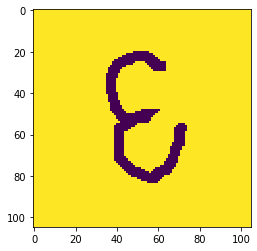

In [0]:
import matplotlib.pyplot as plt
plt.imshow(images[4])

In [0]:
labels[4]

tensor(0.)

In [0]:
images.shape[0]/20 #no of classes

964.0

In [0]:
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(1, 64, 10),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 7),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2),
        nn.Conv2d(128, 128, 4),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2),
        nn.Conv2d(128, 256, 4),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(2304, 964)
  
  def forward(self, x):
    x = self.layers(x)
    x = x.view(-1, self.num_flat_features(x))
    x = F.sigmoid(x)
    x = self.fc1(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

net = Net()
net = net.cuda()
print(net)

Net(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=964, bias=True)
)


In [0]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([64, 1, 10, 10])


In [0]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [0]:
import numpy as np
shuffled_indices = np.random.permutation(19280)
img = images[shuffled_indices,:,:]
lbl = labels[shuffled_indices]

In [0]:
losses = []
for epoch in range(20):
  loss = 0
  for i in range(int(19280/20)):
    #shuffled_indices = np.random.permutation(19280)
    #img = images[shuffled_indices,:,:]
    img2 = img[20*i:20*(i+1)]
    #lbl = labels[shuffled_indices]
    lbl2 = lbl[20*i:20*(i+1)]
    img2 = img2.cuda()
    lbl2 = lbl2.cuda()
    optimizer.zero_grad()

    outputs = net(img2.reshape(20, 1, 105, 105))
    #output_x = F.softmax(outputs, dim = 1)
    #_, argmax = output_x.max(-1)

    loss = criterion(outputs, lbl2.long())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if i%200 == 199:
      print("epoch ->" + str(epoch+1))
      print("batch ->" + str(i+1))
      print("loss ->" + str(loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch ->1
batch ->200
loss ->2852.082763671875
epoch ->1
batch ->400
loss ->4342.9736328125
epoch ->1
batch ->600
loss ->4985.53662109375
epoch ->1
batch ->800
loss ->8538.0625
epoch ->2
batch ->200
loss ->3713.25244140625
epoch ->2
batch ->400
loss ->2628.150634765625
epoch ->2
batch ->600
loss ->2092.2890625
epoch ->2
batch ->800
loss ->2457.767333984375
epoch ->3
batch ->200
loss ->2030.570556640625
epoch ->3
batch ->400
loss ->1880.4228515625
epoch ->3
batch ->600
loss ->1724.9349365234375
epoch ->3
batch ->800
loss ->1961.868896484375
epoch ->4
batch ->200
loss ->2084.159423828125
epoch ->4
batch ->400
loss ->1601.8443603515625
epoch ->4
batch ->600
loss ->1695.036376953125
epoch ->4
batch ->800
loss ->1703.6842041015625
epoch ->5
batch ->200
loss ->1609.786376953125
epoch ->5
batch ->400
loss ->1665.2230224609375
epoch ->5
batch ->600
loss ->1070.1231689453125
epoch ->5
batch ->800
loss ->1972.309814453125
epoch ->6
batch ->200
loss ->1704.3714599609375
epoch ->6
batch ->400
loss

In [0]:
len(losses)

19280

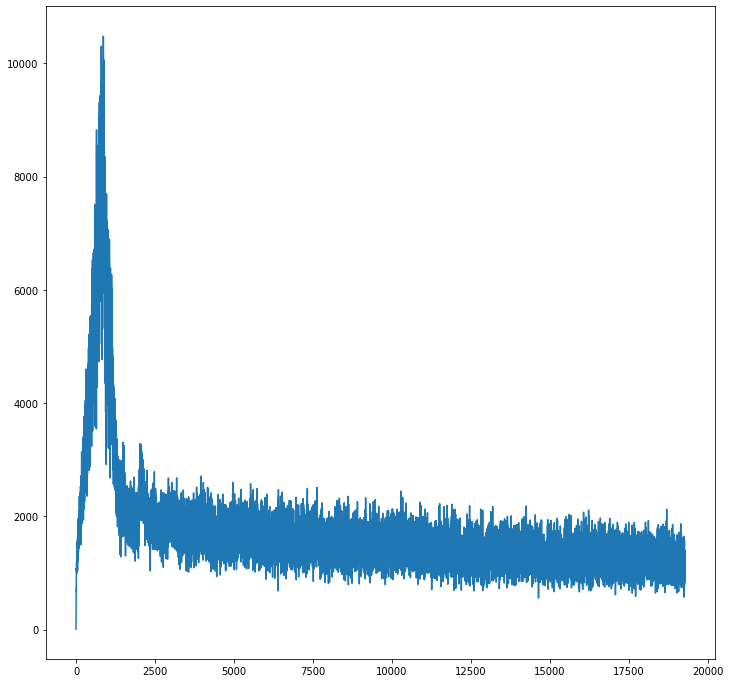

In [0]:
plt.figure(figsize = (12, 12))
plt.plot(np.arange(len(losses)),losses[0:len(losses)])

In [0]:
class Siamese_net(nn.Module):
  def __init__(self):
    super(Siamese_net, self).__init__()
    self.model = nn.Sequential(*list(net.layers[:]))
    self.fc1 = nn.Linear(2304, 4096)
  
  def forward_once(self, x):
    x = self.model(x)
    x = x.view(x.size()[0], -1)
    x = F.sigmoid(self.fc1(x))
    return x
  
  def forward(self, input1, input2):
    output1 = forward_once(input1)
    output2 = forward_once(input2)
    return output1, output2

siamese_net = Siamese_net()
siamese_net = siamese_net.cuda()
print(siamese_net)

Siamese_net(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=4096, bias=True)
)


In [0]:
class contrast_loss(nn.Module):
  def __init__(self, margin = 3.0):
    super(contrast_loss, self).__init__()
    self.margin = margin
  
  def forward(self, output1, output2, label):
    distance = F.pairwise_distance(output1, output2)
    loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss

In [0]:
def one_shot(model, img1, img2):
  output1, output2 = siamese_net(img1.cuda(), img2.cuda())
  distance = F.pairwise_distance(output1, output2)
  if distance>0.5:
    print("same class")
  else:
    print("diff class")